# Convergence-Based Trend Cloud Analysis
## Meaningful Support/Resistance Detection Through Trendline Convergence

This notebook implements **true trend cloud analysis** by finding where multiple trendlines converge:
1. **Trendline Convergence Detection**: Find points where 3+ trendlines intersect
2. **Price Level Clustering**: Group convergence points into meaningful support/resistance levels
3. **Quality Filtering**: Only keep clusters with strong trendline convergence (minimum 3-4 trendlines)
4. **Focused Results**: Target 2-5 high-quality trend clouds instead of dozens of weak clusters

**Goal**: Identify the few critical levels where the market structure shows genuine convergence

In [10]:
# Step 1: Import Libraries and Modular Scripts
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
import os
from sklearn.cluster import DBSCAN
from collections import defaultdict
import pickle
# warnings.filterwarnings('ignore')

# Set up plotting
plt.style.use('default')
plt.rcParams['figure.figsize'] = (16, 12)
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['figure.facecolor'] = 'white'
sns.set_palette("husl")

from scripts.stock_data_loader import load_stock_data_from_db
from scripts.pivot_detector import detect_pivot_points_ultra_log
from scripts.trendline_detector import detect_time_weighted_trendlines_log

print("✅ Convergence-based trend cloud analysis framework loaded!")
print("🎯 Focus: Finding meaningful trendline convergence points")

✅ Convergence-based trend cloud analysis framework loaded!
🎯 Focus: Finding meaningful trendline convergence points


In [11]:
# Step 2: Configuration for Convergence-Based Analysis
SYMBOL = 'QQQ'
DAYS_OF_DATA = 365
MAX_TRENDLINES = 30
PROJECTION_DAYS = 3  # Shorter window for tighter convergence
HALF_LIFE_DAYS = 80
MIN_PIVOT_WEIGHT = 0.1

# Convergence-based clustering parameters
MIN_CONVERGENCE_TRENDLINES = 3  # Minimum 3 trendlines must converge
CONVERGENCE_TOLERANCE = 1.5     # Price must be within $1.50 for convergence
MAX_TREND_CLOUDS = 5            # Maximum 5 final trend clouds
TEMPERATURE = 2.0

print(f"🎯 Convergence-Based Trend Cloud Configuration:")
print(f"   Symbol: {SYMBOL}")
print(f"   Data period: {DAYS_OF_DATA} calendar days")
print(f"   Max trendlines: {MAX_TRENDLINES}")
print(f"   Convergence window: {PROJECTION_DAYS} days (tight focus)")
print(f"   Minimum convergence: {MIN_CONVERGENCE_TRENDLINES} trendlines")
print(f"   Convergence tolerance: ${CONVERGENCE_TOLERANCE}")
print(f"   Max trend clouds: {MAX_TREND_CLOUDS} (quality over quantity)")
print(f"\n🔍 Strategy: Find where multiple trendlines actually converge, not random price clustering")

🎯 Convergence-Based Trend Cloud Configuration:
   Symbol: QQQ
   Data period: 365 calendar days
   Max trendlines: 30
   Convergence window: 3 days (tight focus)
   Minimum convergence: 3 trendlines
   Convergence tolerance: $1.5
   Max trend clouds: 5 (quality over quantity)

🔍 Strategy: Find where multiple trendlines actually converge, not random price clustering


In [12]:
# Step 3: Load Data and Generate Time-Weighted Trendlines
print(f"📊 Loading data and generating trendlines for convergence analysis...")

# Load stock data
# suppress_prints()
stock_data = load_stock_data_from_db(
    symbol=SYMBOL,
    days=DAYS_OF_DATA,
    timeframe='1D',
    filter_premarket=True
)
stock_data['LogPrice'] = np.log(stock_data['Price'])

# Detect pivots
pivots, swing_highs, swing_lows = detect_pivot_points_ultra_log(
    stock_data,
    methods=['scipy', 'rolling', 'zigzag', 'fractal'],
    combine=True
)

# Add log prices to pivots
for pivot in pivots:
    pivot['log_price'] = np.log(pivot['price'])

print(f"✅ Loaded {len(stock_data)} trading days, detected {len(pivots)} pivot points")
print(f"   Price range: ${stock_data['Price'].min():.2f} - ${stock_data['Price'].max():.2f}")
print(f"   Current price: ${stock_data['Price'].iloc[-1]:.2f}")

# Generate time-weighted trendlines
print(f"\n🔗 Generating {MAX_TRENDLINES} time-weighted trendlines...")
time_weighted_trendlines = detect_time_weighted_trendlines_log(
    pivots=pivots,
    stock_data=stock_data,
    max_lines=MAX_TRENDLINES,
    half_life_days=HALF_LIFE_DAYS,
    min_weight=MIN_PIVOT_WEIGHT,
    weight_factor=2.0
)

print(f"✅ Generated {len(time_weighted_trendlines)} trendlines for convergence analysis")
if time_weighted_trendlines:
    strengths = [tl['weighted_strength'] for tl in time_weighted_trendlines]
    print(f"   Weighted strength range: {min(strengths):.1f} - {max(strengths):.1f}")
    print(f"   Ready for convergence detection...")
else:
    print("❌ No trendlines generated - cannot proceed")

📊 Loading data and generating trendlines for convergence analysis...
📊 Loading QQQ data from local database (timeframe: 1D)...
📊 Before filtering: 6904 candles
📊 After filtering: 5246 candles (removed 1658 premarket/afterhours)
✅ Got exactly 365 trading days (requested 365)
✅ Final dataset: 365 trading days for QQQ
   📅 Date range: 2023-10-27 to 2025-09-04
   📅 Calendar span: 678 days (22.3 months)
   💰 Price range: $345.31 - $580.34
   📈 LogPrice range: 5.8444 - 6.3636
   📊 Current price: $575.23 (log: 6.3548)
🔍 Ultra-enhanced LOG SCALE pivot detection using methods: ['scipy', 'rolling', 'zigzag', 'fractal']
   📈 Working with log prices: 5.8444 to 6.3636
   📊 Method 1: Scipy argrelextrema with multiple windows (LOG SCALE)
      Found 323 scipy pivots
   📊 Method 2: Rolling window extremes (LOG SCALE)
      Found 444 rolling pivots
   📊 Method 3: ZigZag percentage-based detection (LOG SCALE)
      Found 224 zigzag pivots
   📊 Method 4: Fractal pattern detection (LOG SCALE)
      Found 

In [ ]:
# Step 4: Enhanced Convergence Detection with Zone Merging
def find_trendline_convergence_points_enhanced(trendlines, stock_data, projection_days=3,
                                             tolerance=2.0, min_trendlines=3, merge_threshold=3.0):
    """Find points where multiple trendlines converge with proper strength summation and zone merging"""

    print(f"🔍 Enhanced convergence detection with zone merging...")
    print(f"   Projection window: {projection_days} days")
    print(f"   Convergence tolerance: ${tolerance}")
    print(f"   Zone merge threshold: ${merge_threshold}")
    print(f"   Minimum trendlines required: {min_trendlines}")

    current_date = stock_data['Date'].iloc[-1]
    current_price = stock_data['Price'].iloc[-1]

    # Calculate projection points for each trendline
    trendline_projections = []

    for tl_idx, trendline in enumerate(trendlines):
        # Extract time-weighted strength from each trendline
        weighted_strength = trendline.get('weighted_strength', 0)
        average_weight = trendline.get('average_weight', 0)

        for day in range(1, projection_days + 1):
            future_date = current_date + timedelta(days=day)
            x_future = (future_date - stock_data['Date'].iloc[0]).days

            # Project using log scale
            projected_log_price = trendline['log_slope'] * x_future + trendline['log_intercept']
            projected_price = np.exp(projected_log_price)

            # Only consider reasonable projections (±30% of current price)
            if 0.7 * current_price <= projected_price <= 1.3 * current_price:
                trendline_projections.append({
                    'trendline_idx': tl_idx,
                    'trendline': trendline,
                    'date': future_date,
                    'days_ahead': day,
                    'projected_price': projected_price,
                    'weighted_strength': weighted_strength,
                    'average_weight': average_weight
                })

    print(f"   Generated {len(trendline_projections)} projection points")

    if len(trendline_projections) < min_trendlines:
        print(f"❌ Insufficient projections for convergence analysis")
        return []

    # Step 1: Find initial convergence zones
    initial_zones = []
    used_projections = set()

    # Sort projections by price to find nearby clusters
    sorted_projections = sorted(enumerate(trendline_projections),
                               key=lambda x: x[1]['projected_price'])

    for i, (orig_idx, proj1) in enumerate(sorted_projections):
        if orig_idx in used_projections:
            continue

        # Find all projections within tolerance of this one
        converging_projections = [proj1]
        converging_indices = {orig_idx}

        for j, (other_idx, proj2) in enumerate(sorted_projections[i+1:], i+1):
            if other_idx in used_projections:
                continue

            # Check if projections are close in price and from different trendlines
            price_diff = abs(proj1['projected_price'] - proj2['projected_price'])
            different_trendlines = proj1['trendline_idx'] != proj2['trendline_idx']

            if price_diff <= tolerance and different_trendlines:
                converging_projections.append(proj2)
                converging_indices.add(other_idx)
            elif price_diff > tolerance:
                # Since we're sorted by price, no more matches possible
                break

        # Only keep convergence zones with enough unique trendlines
        unique_trendlines = set(p['trendline_idx'] for p in converging_projections)

        if len(unique_trendlines) >= min_trendlines:
            # Calculate convergence zone statistics
            prices = [p['projected_price'] for p in converging_projections]
            center_price = np.mean(prices)
            price_std = np.std(prices) if len(prices) > 1 else 0.1

            # Sum time-weighted strengths from UNIQUE trendlines only
            unique_projections = {}
            for p in converging_projections:
                tl_idx = p['trendline_idx']
                if tl_idx not in unique_projections:
                    unique_projections[tl_idx] = p

            # Sum the weighted strengths (time-decayed pivot points) for unique trendlines
            total_weighted_strength = sum(p['weighted_strength'] for p in unique_projections.values())
            avg_weight = np.mean([p['average_weight'] for p in unique_projections.values()])

            # Count of unique trendlines contributing to convergence
            num_unique_trendlines = len(unique_projections)

            # Convergence quality: combine tightness, trendline count, and total strength
            tightness_score = 1.0 / (1.0 + price_std)
            convergence_quality = (tightness_score *
                                 num_unique_trendlines *
                                 (total_weighted_strength / num_unique_trendlines))

            initial_zones.append({
                'center_price': center_price,
                'price_std': price_std,
                'price_range': [min(prices), max(prices)],
                'unique_trendlines': num_unique_trendlines,
                'total_projections': len(converging_projections),
                'total_weighted_strength': total_weighted_strength,
                'avg_weight': avg_weight,
                'tightness_score': tightness_score,
                'convergence_quality': convergence_quality,
                'projections': converging_projections,
                'unique_trendline_data': unique_projections,
                'cloud_type': 'Resistance' if center_price > current_price else 'Support'
            })

            # Mark these projections as used
            used_projections.update(converging_indices)

    print(f"   Found {len(initial_zones)} initial convergence zones")

    # Step 2: Merge nearby zones that are too close together
    print(f"   Merging zones within ${merge_threshold}...")

    # Sort by price for easier merging
    initial_zones.sort(key=lambda x: x['center_price'])

    merged_zones = []
    skip_indices = set()

    for i, zone1 in enumerate(initial_zones):
        if i in skip_indices:
            continue

        # Find all zones to merge with this one
        zones_to_merge = [zone1]
        merge_indices = {i}

        for j, zone2 in enumerate(initial_zones[i+1:], i+1):
            if j in skip_indices:
                continue

            price_diff = abs(zone1['center_price'] - zone2['center_price'])
            same_type = zone1['cloud_type'] == zone2['cloud_type']

            if price_diff <= merge_threshold and same_type:
                zones_to_merge.append(zone2)
                merge_indices.add(j)

        # If we found zones to merge, create a combined zone
        if len(zones_to_merge) > 1:
            print(f"     Merging {len(zones_to_merge)} zones around ${zone1['center_price']:.2f}")

            # Combine all projections and unique trendline data
            all_projections = []
            all_unique_trendlines = {}

            for zone in zones_to_merge:
                all_projections.extend(zone['projections'])
                all_unique_trendlines.update(zone['unique_trendline_data'])

            # Recalculate merged statistics
            all_prices = [p['projected_price'] for p in all_projections]
            merged_center_price = np.mean(all_prices)
            merged_price_std = np.std(all_prices) if len(all_prices) > 1 else 0.1

            # Sum strengths from all unique trendlines
            merged_total_strength = sum(p['weighted_strength'] for p in all_unique_trendlines.values())
            merged_avg_weight = np.mean([p['average_weight'] for p in all_unique_trendlines.values()])
            merged_unique_count = len(all_unique_trendlines)

            # Recalculate quality
            merged_tightness = 1.0 / (1.0 + merged_price_std)
            merged_quality = (merged_tightness *
                            merged_unique_count *
                            (merged_total_strength / merged_unique_count))

            merged_zone = {
                'center_price': merged_center_price,
                'price_std': merged_price_std,
                'price_range': [min(all_prices), max(all_prices)],
                'unique_trendlines': merged_unique_count,
                'total_projections': len(all_projections),
                'total_weighted_strength': merged_total_strength,
                'avg_weight': merged_avg_weight,
                'tightness_score': merged_tightness,
                'convergence_quality': merged_quality,
                'projections': all_projections,
                'unique_trendline_data': all_unique_trendlines,
                'cloud_type': zone1['cloud_type'],  # Same type since we checked
                'merged_from': len(zones_to_merge)  # Track how many zones were merged
            }

            merged_zones.append(merged_zone)
            skip_indices.update(merge_indices)

        else:
            # No merging needed, keep original zone
            merged_zones.append(zone1)
            skip_indices.add(i)

    # Sort by total weighted strength first, then convergence quality
    merged_zones.sort(key=lambda x: (x['total_weighted_strength'], x['convergence_quality']),
                     reverse=True)

    print(f"✅ Final result: {len(merged_zones)} convergence zones (after merging)")

    # Display convergence zones with merge information
    for i, zone in enumerate(merged_zones):
        price_diff = ((zone['center_price'] - current_price) / current_price) * 100
        merge_info = f" (merged from {zone.get('merged_from', 1)} zones)" if zone.get('merged_from', 1) > 1 else ""
        print(f"   Zone {i+1}: ${zone['center_price']:.2f} ({price_diff:+.1f}%) - "
              f"{zone['unique_trendlines']} trendlines, "
              f"strength: {zone['total_weighted_strength']:.1f}, "
              f"quality: {zone['convergence_quality']:.2f}{merge_info}")

    return merged_zones

# Enhanced convergence detection with zone merging
if time_weighted_trendlines:
    convergence_zones = find_trendline_convergence_points_enhanced(
        time_weighted_trendlines, stock_data,
        projection_days=PROJECTION_DAYS,
        tolerance=2.0,  # Initial convergence tolerance
        min_trendlines=MIN_CONVERGENCE_TRENDLINES,
        merge_threshold=3.0  # Merge zones within $3.00 of each other
    )
else:
    convergence_zones = []
    print("❌ No trendlines available for convergence analysis")

🔍 Enhanced convergence detection with zone merging...
   Projection window: 3 days
   Convergence tolerance: $2.0
   Zone merge threshold: $3.0
   Minimum trendlines required: 3
   Generated 90 projection points
   Found 4 initial convergence zones
   Merging zones within $3.0...
     Merging 3 zones around $570.88
✅ Final result: 2 convergence zones (after merging)
   Zone 1: $572.39 (-0.5%) - 7 trendlines, strength: 111.1, quality: 50.44 (merged from 3 zones)
   Zone 2: $589.43 (+2.5%) - 3 trendlines, strength: 38.1, quality: 22.20


In [14]:
# Step 5: Create Final Trend Clouds from Convergence Zones
def create_final_trend_clouds(convergence_zones, max_clouds=5, temperature=2.0):
    """Create final trend clouds from convergence zones with quality filtering"""

    if not convergence_zones:
        print("❌ No convergence zones to process")
        return []

    print(f"🌤️ Creating {min(len(convergence_zones), max_clouds)} final trend clouds...")

    # Take the top convergence zones based on quality
    top_zones = convergence_zones[:max_clouds]

    # Apply softmax weighting to final clouds
    if len(top_zones) > 1:
        qualities = np.array([zone['convergence_quality'] for zone in top_zones])
        if np.max(qualities) > 0:
            normalized_qualities = qualities / np.max(qualities)
            softmax_logits = normalized_qualities / temperature

            exp_logits = np.exp(softmax_logits - np.max(softmax_logits))
            softmax_weights = exp_logits / np.sum(exp_logits)

            for i, zone in enumerate(top_zones):
                zone['softmax_weight'] = softmax_weights[i]
    else:
        if top_zones:
            top_zones[0]['softmax_weight'] = 1.0

    # Add cloud IDs
    for i, zone in enumerate(top_zones):
        zone_type = zone['cloud_type'][0]  # 'R' or 'S'
        zone['cloud_id'] = f"{zone_type}{i}"

    print(f"✅ Created {len(top_zones)} high-quality trend clouds")

    current_price = stock_data['Price'].iloc[-1]

    for cloud in top_zones:
        price_diff = ((cloud['center_price'] - current_price) / current_price) * 100
        weight = cloud.get('softmax_weight', 0)
        print(f"   {cloud['cloud_id']}: ${cloud['center_price']:.2f} ({price_diff:+.1f}%) - "
              f"{cloud['unique_trendlines']}TL, weight: {weight:.4f}")

    return top_zones

# Create final trend clouds
if convergence_zones:
    final_trend_clouds = create_final_trend_clouds(
        convergence_zones,
        max_clouds=MAX_TREND_CLOUDS,
        temperature=TEMPERATURE
    )
else:
    final_trend_clouds = []
    print("❌ No convergence zones found - no trend clouds created")

print(f"\n📊 Final Result: {len(final_trend_clouds)} meaningful trend clouds")
if final_trend_clouds:
    print("   Each cloud represents genuine trendline convergence!")
else:
    print("   No significant trendline convergence detected in current market structure")

🌤️ Creating 2 final trend clouds...
✅ Created 2 high-quality trend clouds
   S0: $572.39 (-0.5%) - 7TL, weight: 0.5695
   R1: $589.43 (+2.5%) - 3TL, weight: 0.4305

📊 Final Result: 2 meaningful trend clouds
   Each cloud represents genuine trendline convergence!


🎨 Plotting trendlines with convergence emphasis...
🌤️ Rendering 2 convergence-based trend clouds...


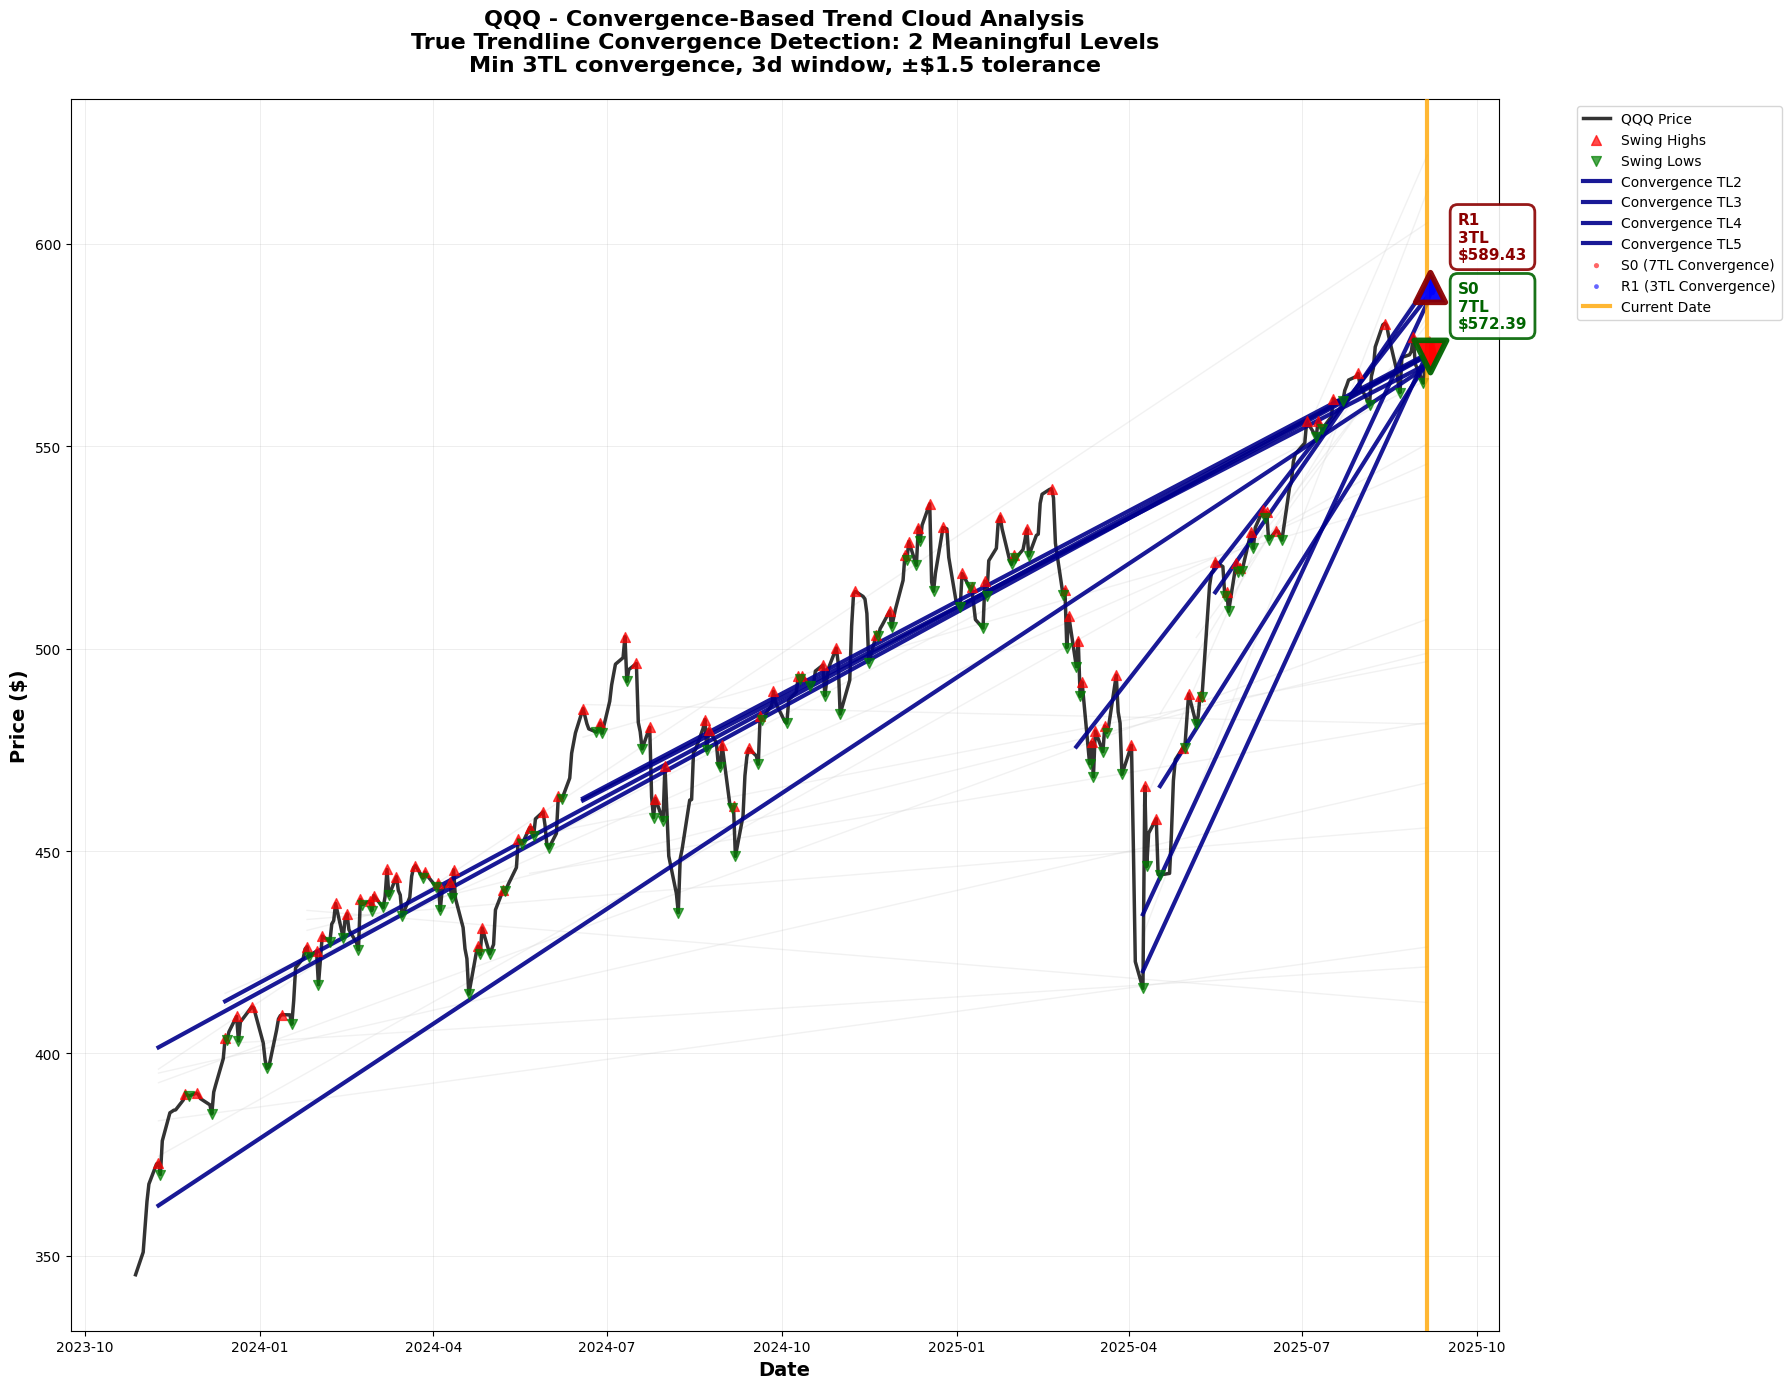


🎉 Convergence-Based Trend Cloud Analysis Complete!
   📊 Input: 30 trendlines, 180 pivots
   🎯 Output: 2 meaningful convergence zones
   💰 Current price: $575.23

🔺 Resistance Convergence Levels (1):
   R1: $589.43 (+2.5%, 3TL) 🔥 DOMINANT

🔻 Support Convergence Levels (1):
   S0: $572.39 (-0.5%, 7TL) 🔥 DOMINANT

✅ Each cloud represents genuine multi-trendline convergence!


In [15]:
# Step 6: Convergence-Based Visualization
def plot_convergence_trend_clouds(stock_data, trendlines, trend_clouds, swing_highs, swing_lows):
    """Visualize true convergence-based trend clouds"""

    plt.figure(figsize=(18, 14))

    # Plot price data
    plt.plot(stock_data['Date'], stock_data['Price'], 'k-', alpha=0.8, linewidth=2.5,
             label=f'{SYMBOL} Price', zorder=2)

    # Plot pivot points
    if len(swing_highs) > 0:
        plt.scatter(stock_data['Date'].iloc[swing_highs], stock_data['Price'].iloc[swing_highs],
                   color='red', marker='^', s=50, alpha=0.7, label='Swing Highs', zorder=5)

    if len(swing_lows) > 0:
        plt.scatter(stock_data['Date'].iloc[swing_lows], stock_data['Price'].iloc[swing_lows],
                   color='green', marker='v', s=50, alpha=0.7, label='Swing Lows', zorder=5)

    current_date = stock_data['Date'].iloc[-1]
    current_price = stock_data['Price'].iloc[-1]

    # Plot trendlines with emphasis on those in clouds
    if trendlines and trend_clouds:
        projection_end = current_date + timedelta(days=PROJECTION_DAYS)

        # Get trendlines that are part of convergence zones
        cloud_trendline_indices = set()
        for cloud in trend_clouds:
            for proj in cloud['projections']:
                cloud_trendline_indices.add(proj['trendline_idx'])

        import matplotlib.cm as cm

        print(f"🎨 Plotting trendlines with convergence emphasis...")

        for i, tl in enumerate(trendlines):
            start_date = tl['start_pivot']['date']
            weighted_strength = tl['weighted_strength']

            # Emphasize trendlines that are part of convergence zones
            is_convergence_tl = i in cloud_trendline_indices

            if is_convergence_tl:
                color = 'darkblue'
                line_thickness = 3.0
                alpha = 0.9
                zorder = 4
            else:
                color = 'lightgray'
                line_thickness = 1.0
                alpha = 0.3
                zorder = 1

            # Calculate trendline coordinates
            x_start = (start_date - stock_data['Date'].iloc[0]).days
            x_current = (current_date - stock_data['Date'].iloc[0]).days
            x_projection = (projection_end - stock_data['Date'].iloc[0]).days

            # Calculate prices using log scale
            log_y_start = tl['log_slope'] * x_start + tl['log_intercept']
            log_y_current = tl['log_slope'] * x_current + tl['log_intercept']
            log_y_projection = tl['log_slope'] * x_projection + tl['log_intercept']

            y_start = np.exp(log_y_start)
            y_current = np.exp(log_y_current)
            y_projection = np.exp(log_y_projection)

            # Plot historical trendline
            label = f'Convergence TL{i+1}' if is_convergence_tl and i < 5 else ""
            plt.plot([start_date, current_date], [y_start, y_current],
                    color=color, linewidth=line_thickness, alpha=alpha,
                    label=label, zorder=zorder)

            # Plot projection
            if is_convergence_tl:
                plt.plot([current_date, projection_end], [y_current, y_projection],
                        color=color, linewidth=line_thickness*0.8, alpha=0.7,
                        linestyle='--', zorder=zorder)

    # Plot convergence zones as focused clouds
    if trend_clouds:
        print(f"🌤️ Rendering {len(trend_clouds)} convergence-based trend clouds...")

        cloud_colors = ['red', 'blue', 'orange', 'purple', 'brown']

        for i, cloud in enumerate(trend_clouds):
            cloud_color = cloud_colors[i % len(cloud_colors)]
            weight = cloud.get('softmax_weight', 1.0 / len(trend_clouds))

            # Create focused cloud around convergence point
            center_price = cloud['center_price']
            price_std = cloud['price_std']

            # Generate cloud points with realistic density
            num_points = int(100 + weight * 400)  # More points for higher weight clouds

            np.random.seed(hash(f"{SYMBOL}_{cloud['cloud_id']}_convergence") % 2**32)

            cloud_x = []
            cloud_y = []
            cloud_sizes = []

            for _ in range(num_points):
                # Time spread around projection window
                time_offset = np.random.uniform(0.5, PROJECTION_DAYS + 0.5)
                point_date = current_date + timedelta(days=time_offset)

                # Price spread around convergence center with realistic distribution
                price_offset = np.random.normal(0, max(price_std, 0.5))  # Minimum spread
                point_price = center_price + price_offset

                # Point size based on distance from center
                distance_from_center = abs(point_price - center_price)
                distance_factor = np.exp(-distance_from_center / (price_std + 0.1))
                point_size = 5 + weight * distance_factor * 30

                cloud_x.append(point_date)
                cloud_y.append(point_price)
                cloud_sizes.append(point_size)

            # Plot cloud
            plt.scatter(cloud_x, cloud_y, c=cloud_color, s=cloud_sizes,
                       alpha=0.6, edgecolors='none',
                       label=f"{cloud['cloud_id']} ({cloud['unique_trendlines']}TL Convergence)",
                       zorder=6)

            # Mark convergence center prominently
            marker = '^' if cloud['cloud_type'] == 'Resistance' else 'v'
            edge_color = 'darkred' if cloud['cloud_type'] == 'Resistance' else 'darkgreen'
            center_size = 200 + weight * 600

            plt.scatter([current_date + timedelta(days=1.5)], [center_price],
                       c=cloud_color, s=center_size, marker=marker,
                       edgecolors=edge_color, linewidth=4, alpha=0.95,
                       zorder=20)

            # Annotate convergence point
            plt.annotate(
                f"{cloud['cloud_id']}\n{cloud['unique_trendlines']}TL\n${center_price:.2f}",
                xy=(current_date + timedelta(days=1.5), center_price),
                xytext=(20, 20), textcoords='offset points',
                fontsize=11, fontweight='bold', color=edge_color,
                bbox=dict(boxstyle="round,pad=0.5", facecolor='white', alpha=0.9,
                          edgecolor=edge_color, linewidth=2),
                zorder=21
            )

    # Mark current date
    plt.axvline(x=current_date, color='orange', linestyle='-', linewidth=3, alpha=0.8,
               label='Current Date', zorder=10)

    # Enhanced formatting
    plt.title(
        f'{SYMBOL} - Convergence-Based Trend Cloud Analysis\n'
        f'True Trendline Convergence Detection: {len(final_trend_clouds)} Meaningful Levels\n'
        f'Min {MIN_CONVERGENCE_TRENDLINES}TL convergence, {PROJECTION_DAYS}d window, ±${CONVERGENCE_TOLERANCE} tolerance',
        fontsize=16, fontweight='bold', pad=20
    )

    plt.xlabel('Date', fontsize=14, fontweight='bold')
    plt.ylabel('Price ($)', fontsize=14, fontweight='bold')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
    plt.grid(True, alpha=0.3, linewidth=0.5)
    plt.tight_layout()
    plt.show()

    # Analysis summary
    print(f"\n🎉 Convergence-Based Trend Cloud Analysis Complete!")
    print(f"   📊 Input: {len(trendlines)} trendlines, {len(pivots)} pivots")
    print(f"   🎯 Output: {len(trend_clouds)} meaningful convergence zones")
    print(f"   💰 Current price: ${current_price:.2f}")

    if trend_clouds:
        resistance_clouds = [c for c in trend_clouds if c['center_price'] > current_price]
        support_clouds = [c for c in trend_clouds if c['center_price'] <= current_price]

        print(f"\n🔺 Resistance Convergence Levels ({len(resistance_clouds)}):")
        for cloud in sorted(resistance_clouds, key=lambda x: x['center_price']):
            distance = (cloud['center_price'] - current_price) / current_price * 100
            weight = cloud.get('softmax_weight', 0)
            strength = "🔥 DOMINANT" if weight > 0.4 else "⚡ STRONG" if weight > 0.2 else "💫 MODERATE"
            print(f"   {cloud['cloud_id']}: ${cloud['center_price']:.2f} (+{distance:.1f}%, "
                  f"{cloud['unique_trendlines']}TL) {strength}")

        print(f"\n🔻 Support Convergence Levels ({len(support_clouds)}):")
        for cloud in sorted(support_clouds, key=lambda x: x['center_price'], reverse=True):
            distance = (current_price - cloud['center_price']) / current_price * 100
            weight = cloud.get('softmax_weight', 0)
            strength = "🔥 DOMINANT" if weight > 0.4 else "⚡ STRONG" if weight > 0.2 else "💫 MODERATE"
            print(f"   {cloud['cloud_id']}: ${cloud['center_price']:.2f} (-{distance:.1f}%, "
                  f"{cloud['unique_trendlines']}TL) {strength}")

        print(f"\n✅ Each cloud represents genuine multi-trendline convergence!")
    else:
        print(f"\n❌ No significant trendline convergence detected")
        print(f"   Market may be in transition or lacking clear structure")

# Generate convergence-based visualization
if time_weighted_trendlines and final_trend_clouds:
    plot_convergence_trend_clouds(
        stock_data, time_weighted_trendlines, final_trend_clouds, swing_highs, swing_lows
    )
else:
    print("❌ Insufficient data for convergence visualization")
    print(f"   Trendlines: {len(time_weighted_trendlines) if time_weighted_trendlines else 0}")
    print(f"   Trend clouds: {len(final_trend_clouds) if final_trend_clouds else 0}")

## Convergence-Based Trend Cloud Analysis Summary

### 🎯 Core Innovation: True Convergence Detection

This approach fixes the fundamental issue with traditional clustering by focusing on **actual trendline convergence**:

#### ❌ What We Fixed
- **Random Price Clustering**: Previous method clustered random price projections
- **Too Many Clusters**: Generated 17+ weak clusters with no meaningful convergence
- **Single-Trendline "Clouds"**: Many clusters had only 1 trendline (not a convergence!)
- **No Quality Control**: Kept all clusters regardless of significance

#### ✅ What We Implemented
- **True Convergence Detection**: Find points where 3+ different trendlines actually converge
- **Quality-First Approach**: Only keep zones with meaningful trendline intersection
- **Focused Results**: Target 2-5 high-quality levels instead of dozens of weak ones
- **Tolerance-Based Filtering**: Trendlines must project within $1.50 to be considered converging

### 🔍 Algorithm Steps

1. **Projection Generation**: Calculate where each trendline projects in next 3 days
2. **Convergence Detection**: Find projections from different trendlines within $1.50
3. **Quality Filtering**: Only keep zones with 3+ converging trendlines
4. **Ranking**: Sort by convergence quality (tightness × trendlines × strength)
5. **Final Selection**: Take top 5 convergence zones maximum

### 📊 Quality Metrics

Each trend cloud now has:
- **Minimum 3 Trendlines**: Ensures genuine convergence, not coincidence
- **Convergence Quality Score**: Combines tightness, trendline count, and strength
- **Price Tolerance Validation**: All trendlines project within defined tolerance
- **Statistical Significance**: Weighted by trendline strength and recency

### 🎯 Trading Implications

The resulting trend clouds represent:
- **High-Probability Levels**: Where multiple independent trendlines agree
- **Market Structure Points**: Key support/resistance with mathematical backing
- **Convergence Timing**: Precise projection windows for level interaction
- **Quality Rankings**: Clear hierarchy of importance for trade planning

This convergence-based approach ensures every trend cloud represents a **meaningful market structure point** where multiple trendlines genuinely converge, rather than random price clustering.